# Conditional Markov Bridge (CMB) for mixed data

### Dataset: 8-gaussians to 2 moons
- continuous: positions in (x,y)-plane
- discrete: 8 position-dependent states 

/home/df630/CMB/src/cmb/datasets/toys.py:141: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return positions * 3 - 1, torch.tensor(labels, dtype=torch.long)
/home/df630/CMB/src/cmb/datasets/toys.py:110: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return positions, torch.tensor(labels, dtype=torch.long)


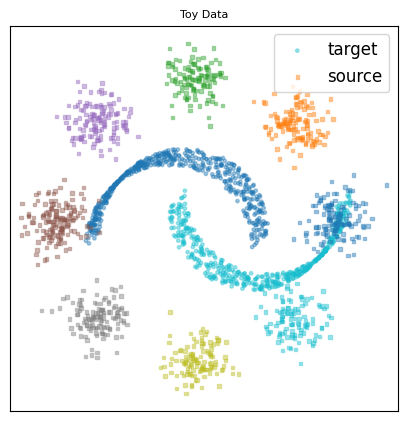

In [1]:
import matplotlib.pyplot as plt
from cmb.configs.experiments import Configs
from cmb.datasets.toys import SampleCoupling

config = Configs('configs.yaml')
toys = SampleCoupling(config=config.data)

_, ax = plt.subplots(1, 1, figsize=(5,5)) 

toys.target.display(num_points=1000, s=6, cmap='tab10', alpha=0.4, ax=ax, label='target')
toys.source.display(num_points=1000, s=6, marker='s', cmap='tab10', alpha=0.4, ax=ax, label='source')

plt.legend(fontsize=12)
plt.title('Toy Data', fontsize=8)
plt.show()

In [2]:
import torch
from torch import nn
from cmb.models.architectures.utils import InputEmbedding, get_activation_function, MLP
from torch.nn.functional import softmax

class MixedDataMLP(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.device = config.train.device
        self.gamma = config.dynamics.gamma
        self.time_epsilon = config.pipeline.time_eps

        #...input data dimensions:
        self.dim_features_continuous = config.data.dim.features.continuous  
        self.dim_features_discrete = config.data.dim.features.discrete
        self.vocab_size = config.data.vocab_size.features            
        dim_context_continuous = config.data.dim.context.continuous 

        #...embedding dimensions:
        dim_time_emb = config.model.dim.embed.time
        dim_features_continuous_emb = config.model.dim.embed.features.continuous if config.model.dim.embed.features.continuous else self.dim_features_continuous
        dim_features_discrete_emb = config.model.dim.embed.features.discrete 
        dim_context_continuous_emb = config.model.dim.embed.context.continuous if config.model.dim.embed.context.continuous else dim_context_continuous
        dim_context_discrete_emb = config.model.dim.embed.context.discrete
                
        #...components:

        self.embedding = InputEmbedding(config)      

        self.layers = MLP(dim_input=dim_time_emb + dim_features_continuous_emb + dim_features_discrete_emb + dim_context_continuous_emb + dim_context_discrete_emb, 
                          dim_output=self.dim_features_continuous + self.dim_features_discrete * self.vocab_size, 
                          dim_hidden=config.model.dim.hidden, 
                          num_layers=config.model.num_layers, 
                          activation=get_activation_function(config.model.activation), 
                          dropout=config.model.dropout, 
                          use_batch_norm=config.model.use_batch_norm)

        self.init_weights()

    def forward(self, t, x, k, context_continuous=None, context_discrete=None, mask=None, output_rates=False):
        t = t.to(self.device) 
        x = x.to(self.device) 
        k = k.to(self.device)
        context_continuous = context_continuous.to(self.device) if isinstance(context_continuous, torch.Tensor) else None 
        context_discrete = context_discrete.to(self.device) if isinstance(context_discrete, torch.Tensor) else None 
        mask = mask.to(self.device) if isinstance(mask, torch.Tensor) else torch.ones_like(t).to(self.device)

        h, _ = self.embedding(t, x, k, context_continuous, context_discrete, mask)
        h = self.layers(h)
        
        continuous_head = h[:, :self.dim_features_continuous]
        discrete_head = h[:, self.dim_features_continuous:]
        logits = discrete_head.reshape(k.size(0), self.dim_features_discrete, self.vocab_size)

        if output_rates: 
            t = t.squeeze()
            t1 = 1. - self.time_epsilon
            beta_integral = (t1 - t) * self.gamma
            wt = torch.exp(-self.vocab_size * beta_integral)
            A = 1.0
            B = (wt * self.vocab_size) / (1. - wt)
            C = wt
            qx = softmax(logits, dim=2)
            qy = torch.gather(qx, 2, k.long().unsqueeze(2))
            rate = A + B[:, None, None] * qx + C[:, None, None] * qy
            return continuous_head, rate
        else:
            return continuous_head, logits

    def init_weights(self):
        for layer in self.layers:
            if isinstance(layer, nn.Linear):
                nn.init.xavier_uniform_(layer.weight)


In [3]:
from cmb.dynamics.cmb import ConditionalMarkovBridge, OTCMB, SBCMB
from cmb.models.trainers import CMBTrainer

dynamics = OTCMB(config)
mixmlp = MixedDataMLP(config)
model = CMBTrainer(config, dynamics, mixmlp, toys)
model.train()

2024-09-21 16:00:57.303506: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-21 16:00:57.346971: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-21 16:00:57.348434: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-21 16:00:58.021677: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


INFO: building dataloaders...
INFO: train/val/test split ratios: 1.0/0.0/0.0
INFO: train size: 70000, validation size: 0, testing sizes: 0


number of training parameters: 41034
start training...


epochs:   0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:

class Pipeline:
    def __init__(self, 
                 trained_model, 
                 config: dataclass=None,
                 best_epoch_model: bool=True
                 ):

        self.config = config
        self.model = trained_model.best_epoch_model if best_epoch_model else trained_model.last_epoch_model
        self.time_steps = torch.linspace(0.0, 1.0 - config.pipeline.time_eps, config.pipeline.num_timesteps)

    @torch.no_grad()
    def generate_samples(self, **source):
        
        if self.config.pipeline.method == 'EulerLeapingSolver':
            solver = EulerLeapingSolver(model=self.model, config=self.config)
            paths, jumps = solver.simulate(time_steps=self.time_steps, **source)
            self.paths = paths.detach().cpu()
            self.jumps = jumps.detach().cpu()


class EulerLeapingSolver:
    ''' Euler-Leaping solver combining Euler and Tau-Leaping methods for mixed data
    '''
    def __init__(self, model, config):
        self.model = model # velocity and rate model
        self.device = config.train.device
        self.dim_discrete = config.data.dim.features.discrete
        self.vocab_size = config.data.vocab_size.features 

    def simulate(self, 
                 time_steps, 
                 source_continuous, 
                 source_discrete, 
                 context_continuous=None, 
                 context_discrete=None, 
                 mask=None, 
                 max_rate_last_step=False):
        
        x = source_continuous.to(self.device)
        k = source_discrete.to(self.device)
        time_steps = time_steps.to(self.device)
        context_continuous = context_continuous.to(self.device) if context_continuous is not None else None
        context_discrete = context_discrete.to(self.device) if context_discrete is not None else None
        mask = mask.to(self.device) if mask is not None else None

        delta_t = (time_steps[-1] - time_steps[0]) / (len(time_steps) - 1)
        paths, jumps = [x.clone()], [k.clone()]

        for time in time_steps[1:]:

            time = torch.full((x.size(0), 1), time.item(), device=self.device)

            #...compute velocity and rates:
            vector, rates = self.model(t=time, 
                                       x=x, 
                                       k=k, 
                                       context_continuous=context_continuous, 
                                       context_discrete=context_discrete,  
                                       output_rates=True)
            
            vector = vector.to(self.device)
            rates = rates.to(self.device)

            #...tau-leaping step:
            max_rate = torch.max(rates, dim=2)[1]
            all_jumps = torch.poisson(rates * delta_t).to(self.device) 
            mask =  torch.sum(all_jumps, dim=-1).type_as(k) <= 1
            diff = torch.arange(self.vocab_size, device=self.device).view(1, 1, self.vocab_size) - k[:,:, None]
            net_jumps = torch.sum(all_jumps * diff, dim=-1).type_as(k)
            k += net_jumps * mask
            k = torch.clamp(k, min=0, max=self.vocab_size-1)            
            jumps.append(k.clone())

            #...euler step:
            x += delta_t * vector
            paths.append(x.clone())
        
        paths = torch.stack(paths)
        jumps = torch.stack(jumps)

        if max_rate_last_step:
            jumps[-1] = max_rate # replace last jump with max rates

        return paths, jumps

In [4]:
from cmb.models.pipelines import Pipeline

pipeline = Pipeline(trained_model=model, config=config)
test = SampleCoupling(config=config.data)
pipeline.generate_samples(source_continuous=test.source.continuous, source_discrete=test.source.discrete.unsqueeze(1), mask=None)


/home/df630/CMB/src/cmb/datasets/toys.py:141: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return positions * 3 - 1, torch.tensor(labels, dtype=torch.long)
/home/df630/CMB/src/cmb/datasets/toys.py:110: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return positions, torch.tensor(labels, dtype=torch.long)


### CMB: 
- $q(x_0, x_1)=q_0(x_0)\cdot q_1(x_1)$
- $q(k_0, k_1)=q_0(k_0)\cdot q_1(k_1)$
- $\gamma=0.125$ 
- $\sigma_{CFM}=0.1$

/tmp/ipykernel_1491123/989848761.py:21: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  ax[j].scatter(paths[0, :N, 0], paths[0, :N, 1], s=1, color='gray', alpha=0.2, vmin=vmin, vmax=vmax)


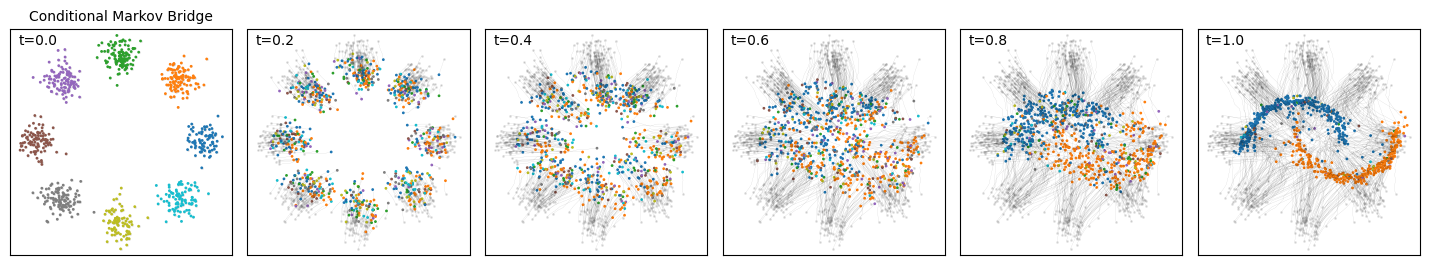

In [35]:
from utils import plot_trajectories

plot_trajectories(pipeline.paths, 
                  pipeline.jumps, 
                  title='Conditional Markov Bridge', 
                  N=800, 
                  show_paths=True)

### Batch OT-CMB:

- $q(x_0, x_1)=\pi_{\rm OT}(x_0 ,x_1)$
- $q(k_0, k_1)=q_0(k_0)\cdot q_1(k_1)$
- $\gamma=0.125$ 
- $\sigma_{CFM}=0.1$

/tmp/ipykernel_1520770/989848761.py:21: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  ax[j].scatter(paths[0, :N, 0], paths[0, :N, 1], s=1, color='gray', alpha=0.2, vmin=vmin, vmax=vmax)


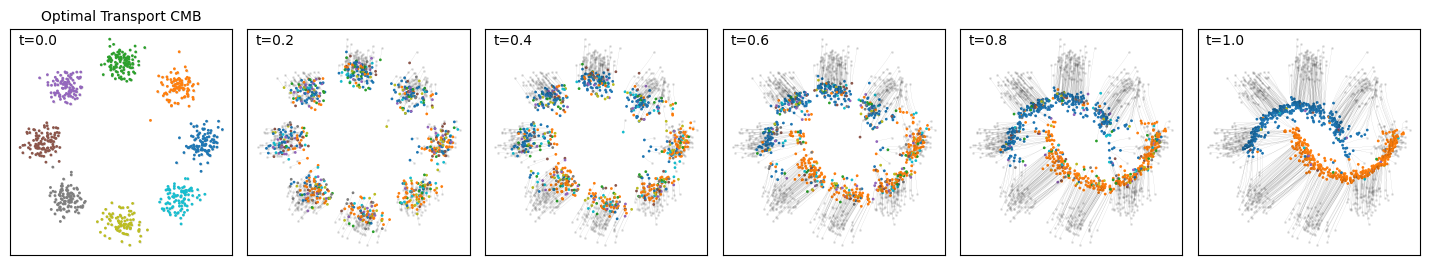

In [6]:
from utils import plot_trajectories

plot_trajectories(pipeline.paths, 
                  pipeline.jumps, 
                  title='Optimal Transport CMB', 
                  N=800, 
                  show_paths=True)

In [8]:
animate_trajectories(pipeline.paths, pipeline.jumps, N=200, cmap='tab10', show_paths=True, filename='trajectories.gif', fps=100)


/tmp/ipykernel_1520770/1936989736.py:25: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  scatter_current = ax.scatter([], [], s=2, cmap=cmap, norm=norm)


Animation saved as trajectories.gif
